In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import datetime, random
import numpy as np; np.random.seed(0)
import warnings
import itertools, os
from zipfile import ZipFile
from urllib.request import urlopen
from io import BytesIO
warnings.filterwarnings('ignore')



**Loading data** 


In [43]:
# Load locally
local = False

if not local:
    # this will download a copy from GitHub and save it locally
    URL = 'https://github.com/amunategui/amunategui.github.io/raw/master/all_stocks_5yr.zip'
    z = urlopen(URL)
    myzip = ZipFile(BytesIO(z.read())).extract('all_stocks_5yr.csv')
    stocks_df = pd.read_csv(myzip)
    
else:
    # read locally saved version
    stocks_df = pd.read_csv('all_stocks_5yr.csv')

In [44]:
stocks_df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [45]:
stocks_df.shape

(619040, 7)

**Preparing data**

In [46]:
stock_symbols=list(set(stocks_df["Name"]))
print(stock_symbols[0:10])


['MAT', 'PNW', 'LUV', 'JNJ', 'REGN', 'JNPR', 'CERN', 'FMC', 'MCD', 'GLW']


In [47]:
# build dataset  
X = []
y = []
symbols = []
prediction_dates = []
last_market_dates = []

# rolling predictions
rolling_period = 5
predict_out_period = 5

for stock in stock_symbols:
    stock_data = stocks_df[stocks_df['Name']==stock].copy()
    
    for per in range(rolling_period, len(stock_data)-predict_out_period):
        X_tmp = []
        y_tmp = 0
        for rollper in range(per-rolling_period,per):
            # build the 'features'
            #get the log to normalize the prices
            X_tmp += [np.log(stock_data['close'].values[rollper])]

        X.append(np.array(X_tmp))
        # build 'labels'
        y.append(np.log(stock_data['close'].values[per + predict_out_period]))
        prediction_dates.append(stock_data['date'].values[per + predict_out_period])
        last_market_dates.append(stock_data['date'].values[per])
        symbols.append(stock)

 



In [48]:
stock_model_ready_df = pd.DataFrame(X)
stock_model_ready_df.columns = [str(f) for f in list(stock_model_ready_df)]
stock_model_ready_df.head()
stock_model_ready_df['outcome'] = y
stock_model_ready_df['date'] = prediction_dates
stock_model_ready_df['last_market_date'] = last_market_dates
stock_model_ready_df['symbol'] = symbols


# write a copy to file to use in our web application
stock_model_ready_df.to_csv('stock_market_historical_data.csv', index=None)

In [49]:
stock_model_ready_df.tail()


,0,1,2,3,4,outcome,date,last_market_date,symbol
613985,3.575991,3.590715,3.609836,3.616040,3.624074,3.603049,2018-02-01,2018-01-25,FOX
613986,3.590715,3.609836,3.616040,3.624074,3.630456,3.589611,2018-02-02,2018-01-26,FOX
613987,3.609836,3.616040,3.624074,3.630456,3.645972,3.571221,2018-02-05,2018-01-29,FOX
613988,3.616040,3.624074,3.630456,3.645972,3.641264,3.595118,2018-02-06,2018-01-30,FOX
613989,3.624074,3.630456,3.645972,3.641264,3.634423,3.575151,2018-02-07,2018-01-31,FOX


In [50]:
# loop the amount of days we don't have an outome
stock_data_live = stocks_df[stocks_df['Name']=='AAPL'].copy()
no_outcome_id = len(stock_data_live)-predict_out_period
future_data = []
prediction_dates = []
last_market_dates = []

# shift everything out into 'no outcome' zone
for per in range(no_outcome_id+1, len(stock_data_live)+1): 
    X_tmp = []
    y_tmp = 0
    for rollper in range(per-rolling_period,per):
        X_tmp += [np.log(stock_data_live['close'].values[rollper])]
    
    future_data.append(np.array(X_tmp))
    last_market_dates.append(stock_data_live['date'].values[rollper])
    # create a business day offset for future dates to avoid weekends and holidays 
    prediction_dates.append(np.busday_offset(np.datetime64(stock_data_live['date'].values[rollper],'D'),predict_out_period, roll='forward'))

future_model_ready_df = pd.DataFrame(future_data)
future_model_ready_df.columns = [str(f) for f in list(future_model_ready_df)]

# outcome here is just a random placeholder, it won't be used
future_model_ready_df['outcome'] = -1
future_model_ready_df['date'] = prediction_dates
future_model_ready_df['last_market_date'] = last_market_dates
future_model_ready_df.head()

,0,1,2,3,4,outcome,date,last_market_date
0,5.144642,5.123726,5.117814,5.120565,5.122654,-1,2018-02-08,2018-02-01
1,5.123726,5.117814,5.120565,5.122654,5.078294,-1,2018-02-09,2018-02-02
2,5.117814,5.120565,5.122654,5.078294,5.052992,-1,2018-02-12,2018-02-05
3,5.120565,5.122654,5.078294,5.052992,5.093934,-1,2018-02-13,2018-02-06
4,5.122654,5.078294,5.052992,5.093934,5.072295,-1,2018-02-14,2018-02-07


**Building the model**

In [51]:
features=[ f for f in stock_model_ready_df.columns if f not in ['outcome']]
features_=[f  for f in stock_model_ready_df.columns if f not in ['date', 'last_market_date', 'symbol','outcome']]
label = 'outcome'

In [52]:
!pip install tensorflow

In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import model_from_json
from sklearn.model_selection import train_test_split

# fix random seed for reproducibility
np.random.seed(7)

x_train, x_test, y_train, y_test = train_test_split(stock_model_ready_df[features], stock_model_ready_df[label], test_size=0.33, random_state=42 )
model= Sequential()
model.add(Dense(5,activation='relu',input_dim=5))
model.add(Dense(5,activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(x_train[features_],y_train, epochs=3, batch_size=5, verbose=1)



Epoch 1/3
82275/82275 [==============================] - 56s 671us/step - loss: 0.2561
Epoch 2/3
82275/82275 [==============================] - 54s 661us/step - loss: 0.0018
Epoch 3/3
82275/82275 [==============================] - 54s 653us/step - loss: 0.0017


In [54]:
scores = model.evaluate(x_test[features_], y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[0], scores*100))


loss: 0.24%


In [55]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [56]:
# deserialize the model
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [57]:
# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer='adam')
score = loaded_model.evaluate(x_test[features_], y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[0], score*100))

loss: 0.24%


In [58]:
# predictions have to be restored for processing
x_evaluate_tmp = stock_model_ready_df.copy()
x_evaluate_tmp = x_evaluate_tmp[x_evaluate_tmp['symbol'] == 'AAPL']

predictions = loaded_model.predict(x_evaluate_tmp[features_])
predictions

array([[4.1724644],
       [4.1679106],
       [4.160984 ],
       ...,
       [5.11229  ],
       [5.1000075],
       [5.091384 ]], dtype=float32)

In [59]:
actuals = x_evaluate_tmp['outcome']
forecasts =  [ item for elem in predictions.tolist() for item in elem] 
print(actuals[0:10])

from sklearn.metrics import mean_squared_error
print('RMSE: (+/- off)', np.sqrt(mean_squared_error(list(actuals), forecasts)))

206126    4.147207
206127    4.161045
206128    4.151196
206129    4.144041
206130    4.118967
206131    4.094463
206132    4.120530
206133    4.107735
206134    4.119227
206135    4.121866
Name: outcome, dtype: float64
RMSE: (+/- off) 0.05082211018623761


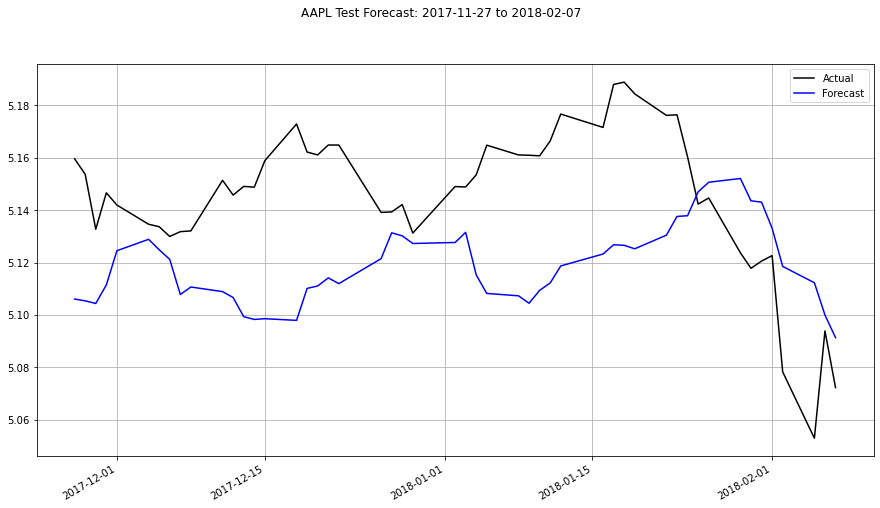

In [60]:
x_done = x_evaluate_tmp.copy()
x_done['forecast'] = forecasts

x_done = x_done.sort_values('date')
x_done = x_done.tail(50)
x_done['date'] = pd.to_datetime(x_done['date'])

fig, ax = plt.subplots(figsize=(15,8))
plt.suptitle('AAPL Test Forecast: ' + str(np.min(x_done['date']))[:10] + ' to '+ str(np.max(x_done['date']))[:10])
plt.plot(x_done['date'] , x_done['outcome'],  color='black', label='Actual')
plt.plot(x_done['date'] , x_done['forecast'],  color='blue', label='Forecast')
plt.legend()
plt.grid()
plt.xticks(rotation='vertical')
ax.xaxis_date()      
fig.autofmt_xdate()
plt.show()

Forecast on live data (basically the last x days where we don't have an outcome...)


2018-02-07 00:00:00


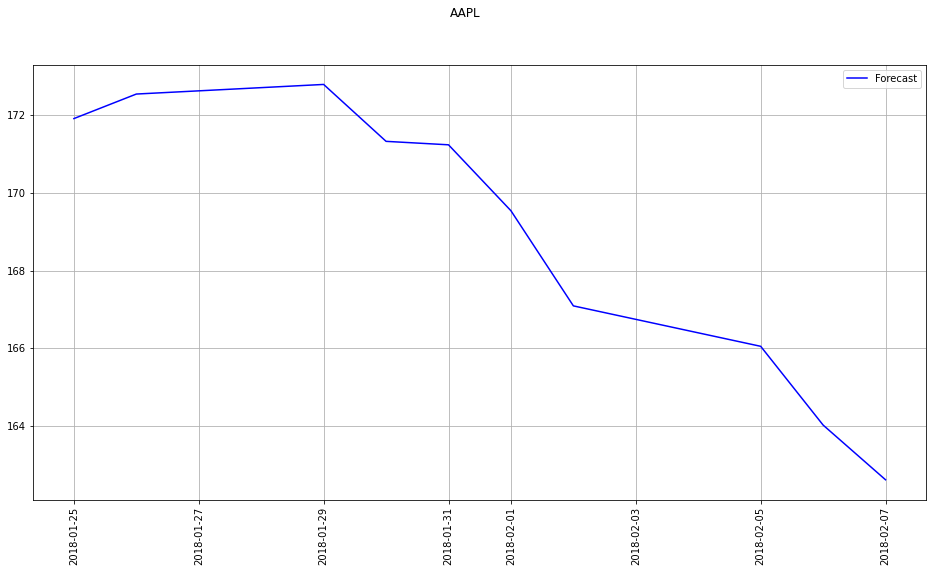

In [61]:
# forecast on live data (basically the last x days where we don't have an outcome...)
predictions = loaded_model.predict(x_evaluate_tmp[features_])
forecasts =  [ item for elem in predictions.tolist() for item in elem] 

future_df_tmp = x_evaluate_tmp.copy()
future_df_tmp['forcast'] = np.exp(forecasts)
future_df_tmp['date'] = pd.to_datetime(future_df_tmp['date'])  

print(np.max(future_df_tmp['date']))
future_df_tmp = future_df_tmp.tail(10)

future_df_tmp = future_df_tmp.sort_values('date')

fig, ax = plt.subplots(figsize=(16, 8))
plt.suptitle('AAPL')
plt.plot(future_df_tmp['date'], future_df_tmp['forcast'], color='blue', label='Forecast')
plt.legend()
plt.grid()
plt.xticks(rotation='vertical')
plt.show()

([<matplotlib.axis.XTick at 0x20913713340>,
 [Text(0.0, 0, '2018-01-31'),
  Text(1.0, 0, '2018-01-30'),
  Text(2.0, 0, '2018-01-29'),
  Text(3.0, 0, '2018-01-26'),
  Text(4.0, 0, '2018-02-01'),
  Text(5.0, 0, '2018-02-02'),
  Text(6.0, 0, '2018-02-05'),
  Text(7.0, 0, '2018-02-06'),
  Text(8.0, 0, '2018-02-07')])

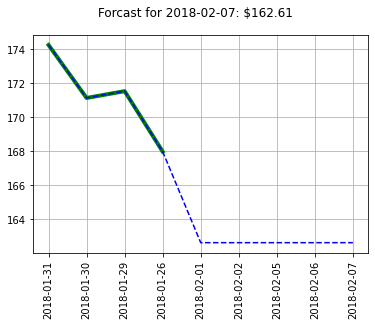

In [62]:
actuals = list(future_df_tmp.tail(1).values[0])[0:predict_out_period-1]
# transform log price to price of past data
actuals = list(np.exp(actuals))
days_before = future_df_tmp['last_market_date'].values[-1]
days_before_list = []
for d in range(rolling_period-1):
    days_before_list.append(str(np.busday_offset(np.datetime64(days_before,'D'),-d, roll='backward')))
     
plt.plot(days_before_list, actuals, color='green', linewidth=4)
 
for d in range(1, predict_out_period+1):
    days_before_list.append(str(np.busday_offset(np.datetime64(days_before,'D'),d, roll='forward')))
    actuals.append(future_df_tmp['forcast'].values[-1])
     

plt.suptitle('Forcast for ' + str(future_df_tmp['date'].values[-1])[0:10] + ': $' + str(np.round(future_df_tmp['forcast'].values[-1],2)))
plt.plot(days_before_list, actuals, color='blue', linestyle='dashed')
plt.grid()
plt.xticks(days_before_list, days_before_list, rotation='vertical')